In [1]:
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch.cuda
import torchvision.transforms as trn
import torchvision.datasets as dset
import torch.optim as optim
import sys

sys.path.append('../../')
from core.models.lipltArchitectures import getNetworkArchitecture
from core.bisectionSolver import createSlopeDictionary
from core.models.model import lipschitzModel

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def calcAnchLip(net, x0):
    with torch.no_grad():
        slopeDictionary, __, maximumValue = createSlopeDictionary('tanh')

        numLayers = (len(net.linear)) // 2
        params = [net.linear[2*i + 1].weight.detach().cpu().numpy() for i in range(numLayers)]
        
        r = np.zeros(len(params))
        r[0] = np.linalg.norm(params[0], 2)

        xmid = net.linear[1](net.linear[0](x0)).reshape(-1)
        for i in range(1, len(params)):
            tmp = []
            for xx in xmid:
                xx = np.minimum(np.abs(xx.item()), 2.00)
                xx = np.round(xx, 2)
                tmp.append(slopeDictionary[xx])
            r[i] = r[i-1] * np.linalg.norm(np.diag(np.array(tmp)) @ params[i].T, 2)

            xmid = net.linear[2*i + 1](net.linear[2*i](xmid)).reshape(-1)

        return r
    
def calcNaiveLip(net):
    with torch.no_grad():
        beta = 1.0
        numLayers = (len(net.linear)) // 2
        params = [net.linear[2*i + 1].weight.detach().cpu().numpy() for i in range(numLayers)]

        r = np.zeros(len(params))
        r[0] = np.linalg.norm(params[0], 2)
        for i in range(1, len(params)):
            r[i] = beta * r[i-1] * np.linalg.norm(params[i].T, 2)
        return r

def calcNaiveCurv(net, r):
    with torch.no_grad():
        beta = 1.0
        betaPrime = 0.7699

        numLayers = (len(net.linear)) // 2
        params = [net.linear[2*i + 1].weight.detach().cpu().numpy() for i in range(numLayers)]

        m = np.zeros(len(params))
        for i in range(1, len(params)):
            subnetLip = r[i]
            layerLipschitz = beta * np.linalg.norm(params[i].T, 2)
            layerJacobianLipschitz = betaPrime * np.linalg.norm(params[i].T, 2)**2
            m[i] = layerJacobianLipschitz * subnetLip ** 2 + layerLipschitz * m[i-1]
        return m


def calcAnchCurv(net, x0, r):
    with torch.no_grad():
        slopeDictionary, curvDictionary, maximumValue = createSlopeDictionary('tanh')
        beta = 1.0
        betaPrime = 0.7699

        numLayers = (len(net.linear)) // 2
        params = [net.linear[2*i + 1].weight.detach().cpu().numpy() for i in range(numLayers)]

        m = np.zeros(len(params))

        x0 = x0.to(torch.device('cuda'))
        net.to(torch.device('cuda'))
        rAnch = calcAnchLip(net, x0)


        
        xmid = net.linear[1](net.linear[0](x0)).reshape(-1)
        for i in range(1, len(params)):
            tmp = []
            for xx in xmid:
                xx = np.minimum(np.abs(xx.item()), 2.00)
                xx = np.round(xx, 2)
                tmp.append(curvDictionary[xx])
            subnetLip = r[i]
            subnetAnchLip = rAnch[i]
            subnetAnchLip = torch.tensor(subnetAnchLip).to(x0.device)
            layerLipschitz = np.linalg.norm(np.diag(np.array(tmp)) @ params[i].T, 2)

            layerJacobianLipschitz = betaPrime * np.linalg.norm(params[i], 2)**2

            m[i] = layerLipschitz * m[i-1] +\
                        layerJacobianLipschitz * subnetLip * subnetAnchLip
        return m

In [3]:
def compareLips(net, dataLoader, device=torch.device('cuda')):
    lipNaives = calcNaiveLip(net)
    anchLip = []
    net.to(torch.device('cuda'))
    for X, Y in tqdm(dataLoader):
        X = X.to(torch.device('cuda'))
        for x in X:
            anchLip.append(calcAnchLip(net, x)[-1])
        break

        
    
    print("Naive Lipschitz: ", lipNaives[-1])
    # print(anchLip)
    print("Anchored Lipschitz: ", np.mean(anchLip))
    return lipNaives, np.mean(anchLip), np.std(anchLip)

def compareCurves(net, dataLoader, r, device=torch.device('cuda')):
    curvNaives = calcNaiveCurv(net, r)
    anchCurv = []
    r = torch.Tensor(r)
    r = r.to(torch.device('cuda'))
    net.to(torch.device('cuda'))
    for X, Y in tqdm(dataLoader):
        X.to(torch.device('cuda'))
        for x in X:
            anchCurv.append(calcAnchCurv(net, x, r)[-1])
        break
   
    
    print("Naive Curv: ", curvNaives[-1])
    print("Anchored Curv: ", np.mean(anchCurv))
    return curvNaives, np.mean(anchCurv), np.std(anchCurv)

In [4]:
def dataLoaders():
    test_transform = trn.Compose([trn.ToTensor(), trn.Normalize(0, 1)])
    train_transform = trn.Compose([trn.ToTensor(), trn.Normalize(0, 1)])

    test_data = dset.MNIST('./data/mnist', train=False, transform=test_transform, download=True)
    train_data = dset.MNIST('./data/mnist', train=True, transform=test_transform, download=True)

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=4, shuffle=False,
        num_workers=4, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=256, shuffle=False,
        num_workers=4, pin_memory=True)
    return train_loader, test_loader

def train(net, train_loader, reg=False):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.to(torch.device('cuda'))
    for __ in tqdm(range(10)):
        for X, Y in train_loader:
            X = X.to(torch.device('cuda'))
            Y = Y.to(torch.device('cuda'))

            optimizer.zero_grad()
            out = net(X)
            loss = torch.nn.functional.cross_entropy(out, Y)
            if reg == True:
                numLayers = (len(net.linear)) // 2
                paramNorms = torch.Tensor([torch.norm(net.linear[2*i + 1].weight) for i in range(numLayers)])
                loss += 0.01 * torch.prod(paramNorms)
            loss.backward()
            optimizer.step()
    return net
        

In [5]:
class Config:
    def __init__(self):
        config = {'model_name':'liplt-' + '3F'}

config = Config()

In [6]:
def run(trainNet=False):
    for arch in ['3F', '4F', '5F', '6F']:
        print(arch + '-------------------')
        x0 = torch.randn(1, 1, 28, 28)
        config.model_name = 'liplt-' + arch
        config.networkConfiguration = {"perClassLipschitz": False,
                                "activation": 'tanh',
                                'learnableBeta': False,
                                "numberOfPowerIterations": 2,
                                "inputShape": x0.shape,
                                "modelType": "liplt",
                                'layers': getNetworkArchitecture(arch),
                                "weightInitialization": "standard",
                                'pairwiseLipschitz': False,
                                'architecture': None,
                                'numberOfClasses': 10, }

        net =  lipschitzModel(config, 10, 'tanh')
        train_loader, test_loader = dataLoaders()
        if trainNet:
            net = train(net, train_loader, reg=True)
        torch.save(net.state_dict(), './' + arch + '-reg' + '.pt')

In [7]:
run(trainNet=True)

3F-------------------


  0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
def eval():
    naive, anch = [], []
    naivC, anchC = [], []
    anchVar, anchCVar = [], []
    for arch in ['3F', '4F']:
        print(arch + '-------------------')
        x0 = torch.randn(1, 1, 28, 28)
        config.model_name = 'liplt-' + arch
        config.networkConfiguration = {"perClassLipschitz": False,
                                "activation": 'tanh',
                                'learnableBeta': False,
                                "numberOfPowerIterations": 2,
                                "inputShape": x0.shape,
                                "modelType": "liplt",
                                'layers': getNetworkArchitecture(arch),
                                "weightInitialization": "standard",
                                'pairwiseLipschitz': False,
                                'architecture': None,
                                'numberOfClasses': 10, }

        net =  lipschitzModel(config, 10, 'tanh')
        net.load_state_dict(torch.load('./' + arch + '.pt'))
        net.eval()
        train_loader, test_loader = dataLoaders()
        lip, anchMean, anchStd = compareLips(net, test_loader)
        naive.append(lip[-1]), anch.append(anchMean), anchVar.append(anchStd)
        print('****')
        curv, anchMean, anchStd = compareCurves(net, test_loader, lip)
        naivC.append(curv[-1]), anchC.append(anchMean), anchCVar.append(anchStd)
    return naive, anch, naivC, anchC, anchVar, anchCVar

In [31]:
naive, anch, naivC, anchC,  anchVar, anchCVar  = eval()

3F-------------------


  0%|          | 0/40 [01:44<?, ?it/s]


Naive Lipschitz:  150.24845645821804
Anchored Lipschitz:  77.43832710167635
****


  0%|          | 0/40 [03:17<?, ?it/s]


Naive Curv:  315309.50515786593
Anchored Curv:  143243.192416572
4F-------------------


  0%|          | 0/40 [01:45<?, ?it/s]


Naive Lipschitz:  549.0313768694923
Anchored Lipschitz:  206.77327362428844
****


  0%|          | 0/40 [03:18<?, ?it/s]


Naive Curv:  4420295.562514891
Anchored Curv:  1445152.5805298886
5F-------------------


KeyError: 'jacobianLipschitzEigenvectorDictionary'

NameError: name 'anch' is not defined

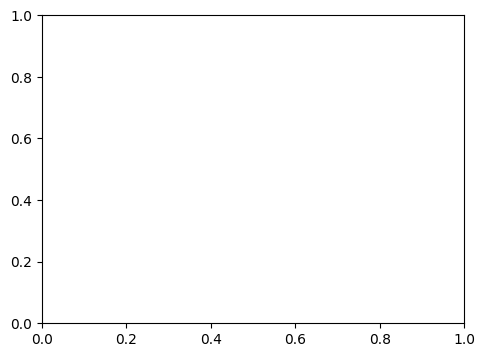

In [32]:
xranges = [3, 4, 5, 6]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
# plt.plot(xranges, naive, marker='^', label='Global Lipschitz')
plt.errorbar(xranges, anch, marker='^', label='Anchored Lipschitz', color='orange')
plt.fill_between(xranges, anch - np.array(anchVar), anch + np.array(anchVar), alpha=0.2, color='orange')
plt.xlabel('Number of Layers')
# plt.yscale('log')
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot(xranges, naivC, marker='^', label='Global Curvature')
plt.errorbar(xranges, anchC, marker='^', label='Anchored Curvature',color='orange')
plt.fill_between(xranges, anchC - np.array(anchCVar), anchC + np.array(anchCVar), alpha=0.2, color='orange')
plt.xlabel('Number of Layers')
# plt.yscale('log')
plt.legend()

# plt.subplot(2, 2, 3)
# plt.plot(xranges, randNaive, label='Naive Lipschitz')
# plt.plot(xranges, randAnch, label='Anchored Lipschitz')
# plt.legend()


# plt.subplot(2, 2, 4)
# plt.plot(xranges, randNaivC, label='Naive Curvature')
# plt.plot(xranges, randAnchC, label='Anchored Curvature')
# plt.xlabel('Number of Layers')
# # plt.yscale('log')
# plt.legend()
plt.savefig('anchExp.png')
plt.savefig('anchExp.pdf')
plt.show()

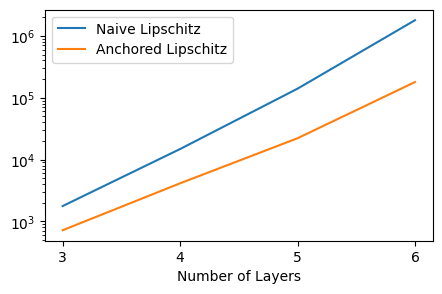

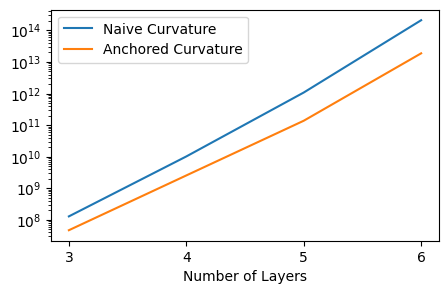

In [11]:
plt.figure(figsize=(5, 3))
plt.plot(xranges, naive, label='Global Lipschitz')
plt.plot(xranges, anch, label='Anchored Lipschitz')
plt.yscale('log')
plt.xticks([3, 4, 5, 6])
plt.xlabel('Number of Layers')
plt.legend()
plt.savefig('anchExp1.pdf', bbox_inches='tight')

plt.figure(figsize=(5, 3))
plt.plot(xranges, naivC, label='Global Curvature')
plt.plot(xranges, anchC, label='Anchored Curvature')
plt.yscale('log')
plt.xlabel('Number of Layers')
plt.xticks([3, 4, 5, 6])
plt.legend()
plt.savefig('anchExp2.pdf', bbox_inches='tight')


# plt.figure(figsize=(6, 3))
# plt.plot(xranges, randNaive, label='Naive Lipschitz')
# plt.plot(xranges, randAnch, label='Anchored Lipschitz')
# plt.xlabel('Number of Layers')
# plt.legend()
# plt.savefig('anchExp3.pdf')

# plt.figure(figsize=(6, 3))
# plt.plot(xranges, randNaivC, label='Naive Curvature')
# plt.plot(xranges, randAnchC, label='Anchored Curvature')
# plt.xlabel('Number of Layers')
# plt.legend()
# plt.savefig('anchExp4.pdf')

plt.show()